# Data Description

The dataset consists of data scraped from __[PropertyGuru.com.my](https://www.propertyguru.com.my/new-property-launch)__ on 1st February 2024. Property.com.my is one of the most comprehensive Malaysia Property website. The dataset contains detail information of new property listed for sell on the website. The objective is to analyze what are the factors that impacted the housing price most.

### About the Dataset

- __title__ -  Title
- __status__ - Status, example New Launch, Open for Sale etc
- __type__ - Type, example Apartment, Condominium, etc
- __tenure__ - Tenure, example Freehold, Leasehold etc
- __price__ - Price in RM
- __built_up_size__ - Built up size in square feet
- __bedroom__ - Number of bedroom
- __bathroom__ - Number of bathroom
- __car_park__ - Number of car park
- __address__ - Address
- __description__ - Description
- __link__ - Link to project information

In [1]:
# import required packages
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt

# to display chart correctly
%matplotlib inline

### Understand the Dataset

In [2]:
date = '2024-02-01'
# read the dataset to data frame
df = pd.read_csv(f'..\data\iproperty_new_listed_projects_{date}.csv')

# see the data structure from first 5 rows
df.head()

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,address,description,link
0,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,473499.0,953 sq. ft.,3,2,2,"Kota Kemuning, Shah Alam, Selangor",Ready to Move In! Register today and save on C...,https://www.iproperty.com.my/new-property/prop...
1,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,555579.0,"1,068 sq. ft.",3,2,2,"Kota Kemuning, Shah Alam, Selangor",Ready to Move In! Register today and save on C...,https://www.iproperty.com.my/new-property/prop...
2,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,582084.0,"1,180 sq. ft.",4,4,2,"Kota Kemuning, Shah Alam, Selangor",Ready to Move In! Register today and save on C...,https://www.iproperty.com.my/new-property/prop...
3,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,676800.0,1464,4,3,2,"Kajang, Selangor","Nestled amidst lush hills, JHomes is a low-den...",https://www.iproperty.com.my/new-property/prop...
4,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,678800.0,1464,4,3,2,"Kajang, Selangor","Nestled amidst lush hills, JHomes is a low-den...",https://www.iproperty.com.my/new-property/prop...


In [3]:
# check the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          281 non-null    object 
 1   status         281 non-null    object 
 2   type           281 non-null    object 
 3   tenure         281 non-null    object 
 4   land_title     281 non-null    object 
 5   price          281 non-null    float64
 6   built_up_size  281 non-null    object 
 7   bedroom        281 non-null    int64  
 8   bathroom       281 non-null    int64  
 9   car_park       281 non-null    int64  
 10  address        281 non-null    object 
 11  description    281 non-null    object 
 12  link           281 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 28.7+ KB


This dataset contains 281 rows and there is no null value in the dataset.
Data type for some columns need to be corrected
- title, object to string
- status, object to string
- type, object to string
- tenure, object to string
- land_title, object to string
- address, object to string
- built_up_size, object to int64

Description can be used in WorldCloud visualization but not in the analysis here.
We can drop the columns for description and link since these columns are not needed for the analyze here.

In [4]:
# check for the value counts for status
df.status.value_counts()

status
New Launch                           146
Open for Sale                         76
Open for Registration                 33
Completed Project                     23
Open for SaleGreat Property Deals      3
Name: count, dtype: int64

3 rows with status "Open for SaleGreat Property Deals" and this sentence looks like a combination of "Open for Sale" and "Great Property Deals". We can go to the project link and check whether this is a data issue and change the status accordingly.

In [5]:
# check for the value counts for type
df.type.value_counts()

type
Serviced Residence          71
2-sty Terrace/Link House    68
Condominium                 39
Apartment                   25
Semi-detached House         20
Shop Office                 14
Bungalow                     8
1-sty Terrace/Link House     6
Townhouse                    5
Shop                         4
Detached factory             4
Industrial Land              3
Cluster House                3
Soho                         3
Semi-D factory               2
Suites                       2
4-sty Terrace/Link House     2
Sovo                         1
Office                       1
Name: count, dtype: int64

We can add one column to categorize property type to "House", "Factory", "Land" and "Shop or Office"

In [6]:
# check for the value counts for tenure
df.tenure.value_counts()

tenure
Freehold               188
Leasehold               84
Lease Tenancy            3
Unknown                  3
Lease                    2
Malay Reserved Land      1
Name: count, dtype: int64

We can change the tenure for "Lease Tenancy" and "Lease" to "Leasehold".<br>
We can also get the property information from link for rows with "Unknown" tenure and correct it.

In [7]:
# check for the value counts for tenure
df.land_title.value_counts()

land_title
Residential    183
Commercial      80
Industrial       9
Unknown          9
Name: count, dtype: int64

We can also get the property information from link for rows with "Unknown" land title and correct it.

### Preprocess the Dataset

In [8]:
# change the data type object to string
df.title = df.title.astype('string')
df.status = df.status.astype('string')
df.type = df.type.astype('string')
df.tenure = df.tenure.astype('string')
df.land_title = df.land_title.astype('string')
df.address = df.address.astype('string')

In [9]:
# change the data type object to int64
# from head we noticed that first 3 rows of build_up_size contains string value
def get_built_up_size(text):
    # value of build up size in the data can be in any 
    # following format, "953 sq. ft.", "1,180 sq. ft.", 
    # "From 1,200 sq. ft.", "1,778 - 2,137 sqft"
    # "2,322 – 2,442 sqft", "1,047 / 1,096 sq. ft."
    text = re.sub(r'[^0-9-–/]', '', text)
    # get the left (min) value
    match = re.search(r'\D*(\d+)', text)
    text = match.group(1)
    return int(text)

df.built_up_size = df.built_up_size.apply(lambda row: get_built_up_size(row))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          281 non-null    string 
 1   status         281 non-null    string 
 2   type           281 non-null    string 
 3   tenure         281 non-null    string 
 4   land_title     281 non-null    string 
 5   price          281 non-null    float64
 6   built_up_size  281 non-null    int64  
 7   bedroom        281 non-null    int64  
 8   bathroom       281 non-null    int64  
 9   car_park       281 non-null    int64  
 10  address        281 non-null    string 
 11  description    281 non-null    object 
 12  link           281 non-null    object 
dtypes: float64(1), int64(4), object(2), string(6)
memory usage: 28.7+ KB


In [10]:
# check property information with the link for "Open for SaleGreat Property Deals" status 
pd.set_option('display.max_colwidth', None)
print(df[df.status=='Open for SaleGreat Property Deals'].link)
pd.set_option('display.max_colwidth', 20)

243    https://www.iproperty.com.my/new-property/property/petaling-jaya/the-atera-petaling-jaya/new-6546/
244    https://www.iproperty.com.my/new-property/property/petaling-jaya/the-atera-petaling-jaya/new-6546/
245    https://www.iproperty.com.my/new-property/property/petaling-jaya/the-atera-petaling-jaya/new-6546/
Name: link, dtype: object


In [11]:
# status for the rows with status "Open for SaleGreat Property Deals" is "Open for Sale" from the property information page
# change the status to "Open for Sale"
df.loc[df.status == 'Open for SaleGreat Property Deals', 'status'] = 'Open for Sale'
df.status.value_counts()

status
New Launch               146
Open for Sale             79
Open for Registration     33
Completed Project         23
Name: count, dtype: Int64

In [12]:
# add one column to categorize property type to "House", "Factory", "Land" and "Shop or Office"
def get_propert_type(text):
    if text in ('Detached factory', 'Semi-D factory'):
        return "Factory"
    elif text in ('Shop Office', 'Shop', 'Sovo', 'Office'):
        return "Shop or Office"
    elif text in ('Industrial Land'):
        return "Land"    
    else:
        # note that for this EDA we consider Soho as house
        # although it can be used as office also
        return "House"

df['category']= df.type.apply(lambda row: get_propert_type(row))
df.category.value_counts()

category
House             252
Shop or Office     20
Factory             6
Land                3
Name: count, dtype: int64

In [13]:
# change the tenure for "Lease Tenancy" and "Lease" to "Leasehold".
df.loc[df.tenure == 'Lease Tenancy', 'tenure'] = 'Leasehold'
df.loc[df.tenure == 'Lease', 'tenure'] = 'Leasehold'

In [14]:
# check property information with the link for "Unknown" tenure
pd.set_option('display.max_colwidth', None)
print(df[df.tenure=='Unknown'].link)
pd.set_option('display.max_colwidth', 20)

221    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
222    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
223    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
Name: link, dtype: object


In [15]:
# tenure from iProperty property information page is Unknown
# googled the propety information showing the tenure is Leasehold
df.loc[df.tenure == 'Unknown', 'tenure'] = 'Leasehold'
df.tenure.value_counts()

tenure
Freehold               188
Leasehold               92
Malay Reserved Land      1
Name: count, dtype: Int64

In [16]:
# check property information with the link for "Unknown" land title
pd.set_option('display.max_colwidth', None)
print(df[df.land_title=='Unknown'].link)
pd.set_option('display.max_colwidth', 20)

35               https://www.iproperty.com.my/new-property/property/nilai/nilai-impian-emilia-3/new-6510/
36               https://www.iproperty.com.my/new-property/property/nilai/nilai-impian-emilia-3/new-6510/
37               https://www.iproperty.com.my/new-property/property/nilai/nilai-impian-emilia-3/new-6510/
54              https://www.iproperty.com.my/new-property/property/kl-city/legasi-kampong-bharu/new-5936/
55              https://www.iproperty.com.my/new-property/property/kl-city/legasi-kampong-bharu/new-5936/
56              https://www.iproperty.com.my/new-property/property/kl-city/legasi-kampong-bharu/new-5936/
221    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
222    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
223    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
Name: link, dtype: object


In [17]:
# land title from iProperty property information page is Unknown
# googled the propety information showing land title is Residential
df.loc[df.land_title == 'Unknown', 'land_title'] = 'Residential'
df.land_title.value_counts()

land_title
Residential    192
Commercial      80
Industrial       9
Name: count, dtype: Int64

In [18]:
# add city and state columns
def get_city(text):
    split_items = text.split(',')
    city = split_items[-2]
    state = split_items[-1]

df['city']= df.address.apply(lambda row: row.split(',')[-2].strip())
df['state']= df.address.apply(lambda row: row.split(',')[-1].strip())

In [19]:
df.city.value_counts()

city
Shah Alam                     26
Johor Bahru                   17
Iskandar Puteri (Nusajaya)    14
Semenyih                      14
Petaling Jaya                 12
Puchong                       11
Subang Jaya                   10
Kajang                        10
Rawang                        10
Kuala Langat                   9
KL City                        7
Pasir Gudang                   7
Bangsar                        6
Gelang Patah                   6
Mont Kiara                     6
Bandar Puncak Alam             6
Cyberjaya                      6
Seri Kembangan                 6
Ampang Hilir                   6
Sepang                         6
Nilai                          6
Setapak                        6
Bayan Lepas                    5
Labu                           4
Bukit Bintang                  4
Muar                           3
Kota Kinabalu                  3
Mount Austin                   3
Kepala Batas                   3
Pulau Langkawi                 3
Kayu 

In [20]:
df.state.value_counts()

state
Selangor           148
Johor               59
Kuala Lumpur        38
Penang              14
Negeri Sembilan     13
Sabah                3
Kedah                3
Terengganu           2
Pahang               1
Name: count, dtype: int64

In [21]:
# drop unused columns
df.drop(['address', 'link', 'description'], axis=1, inplace=True)
df.head()

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state
0,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,473499.0,953,3,2,2,House,Shah Alam,Selangor
1,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,555579.0,1068,3,2,2,House,Shah Alam,Selangor
2,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,582084.0,1180,4,4,2,House,Shah Alam,Selangor
3,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,676800.0,1464,4,3,2,House,Kajang,Selangor
4,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,678800.0,1464,4,3,2,House,Kajang,Selangor


In [22]:
# some of the iProperty project information pages consist dirty data that will result in duplication of records
# check is the data frame contains any duplicated records
df[df.duplicated()]

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state
10,Maya Ara Residences,New Launch,Serviced Residence,Freehold,Commercial,594800.0,764,2,2,0,House,Ara Damansara,Selangor
28,Ilham Residence 3,New Launch,2-sty Terrace/Li...,Freehold,Residential,903888.0,1964,4,4,2,House,Shah Alam,Selangor
140,J.Satine Residen...,New Launch,Apartment,Leasehold,Commercial,300000.0,800,3,2,1,House,Setapak,Kuala Lumpur
157,Casablanca 3,Open for Sale,Cluster House,Freehold,Residential,1702800.0,3048,4,5,2,House,Shah Alam,Selangor
167,"Phase 6M, Rini H...",Open for Sale,2-sty Terrace/Li...,Leasehold,Residential,672000.0,2280,4,4,0,House,Skudai,Johor
169,Isadora,New Launch,2-sty Terrace/Li...,Freehold,Residential,1158000.0,2266,4,4,4,House,Cyberjaya,Selangor
209,Serai Avenue 2 &...,Open for Registr...,Shop Office,Leasehold,Commercial,1368000.0,2656,0,4,0,Shop or Office,Rawang,Selangor
244,"The Atera, Petal...",Open for Sale,Serviced Residence,Leasehold,Commercial,633800.0,775,2,2,0,House,Petaling Jaya,Selangor
274,Setia Versa,Open for Sale,Detached factory,Freehold,Industrial,7700000.0,20013,0,0,0,Factory,Gelang Patah,Johor


In [23]:
# remove duplicated records from data frame
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state


In [24]:
# save the processed data frame to csv file
df.to_csv(f'..\data\iproperty_new_listed_project_{date}_eda.csv', sep=',', encoding='utf-8', index=False)

### Analyze the Dataset

In [25]:
# we only interested on housing price, get house category from the data frame
df_house = df[df.category=='House']

In [26]:
df_house.describe(include='all')

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state
count,245,245,245,245,245,2.450000e+02,245.000000,245.000000,245.000000,245.000000,245,245,245
unique,107,4,12,3,2,NaN,NaN,NaN,NaN,NaN,1,47,9
top,Amverton Greens,New Launch,Serviced Residence,Freehold,Residential,NaN,NaN,NaN,NaN,NaN,House,Shah Alam,Selangor
freq,3,137,69,163,188,NaN,NaN,NaN,NaN,NaN,245,23,139
mean,NaN,NaN,NaN,NaN,NaN,1.002234e+06,1701.742857,3.167347,2.877551,1.628571,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,6.741138e+05,970.091239,1.221627,1.397196,1.407241,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,2.000000e+05,223.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,5.820840e+05,955.000000,3.000000,2.000000,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,8.058880e+05,1510.000000,3.000000,3.000000,2.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.255000e+06,2197.000000,4.000000,4.000000,2.000000,NaN,NaN,NaN


- this housing dataset contains 107 property projects
- median value for housing price is RM804,544, maximum is RM4,248,800 and minimum is RM200,000. More than RM4,000,000 difference between the maximum and minimum price.
- median value for built up size is 1,537.50 square feet, maximum is 5,640.00 square feet and minimum is 223.00 square feet. More than 5,000 square feet difference between the maximum and minimum built up size.
- median value for number of bedroom is 3, maximum is 7 and minimum is 0. It does not make sense for a house with 0 bedroom, we can investigate this further.
- median value for number of bathroom is 3, maximum is 8 and minimum is 0. It does not make sense for a house with 0 bathroom, we can investigate this further.
- median value for number of car park is 2, maximum is 9 and minimum is 0. We can see that even 25th percentile for the number of car park is 0, it seems quite a number of developers do not provide car park information for their projects.

In [27]:
# filter unique property projects
df_unique_title = df_house.copy()
# drop information related to unit type
df_unique_title.drop(['price', 'built_up_size', 'bedroom', 'bathroom', 'car_park'], axis=1, inplace=True)
# drop duplicated rows
df_unique_title.drop_duplicates(inplace=True)
pd.set_option('display.max_colwidth', 30)
df_unique_title.describe(include='all')

,title,status,type,tenure,land_title,category,city,state
count,107,107,107,107,107,107,107,107
unique,107,4,12,3,2,1,47,9
top,Amverton Greens,New Launch,2-sty Terrace/Link House,Freehold,Residential,House,Shah Alam,Selangor
freq,1,60,30,71,80,107,10,61


- 56.07% of this housing dataset is new launch projects
- 28.04% of this housing dataset is 2-sty terrace/link house
- 66.36% of this housing dataset is freehold
- 74.77% of this housing dataset with residential land title
- 9.35% of this housing dataset in Shah Alam city
- 57.01% of this housing dataset in Selangor state

In [52]:
def draw_pie_chart_for_projects(data, target_column, agg_count_column, title):
    target = data[target_column].value_counts().reset_index(name='total')
    plt.pie(
        x=target['total'], 
        labels=target[target_column],
        autopct='%1.2f%%',
        colors=sns.color_palette('colorblind'),
        startangle=90,
        wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
    )
    plt.tight_layout()
    plt.title(title)
    plt.show() 


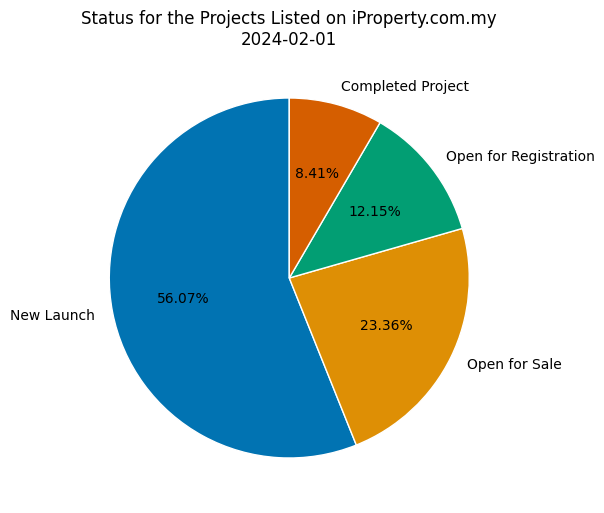

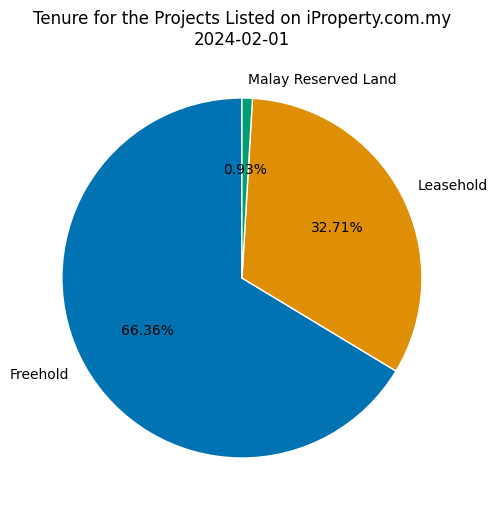

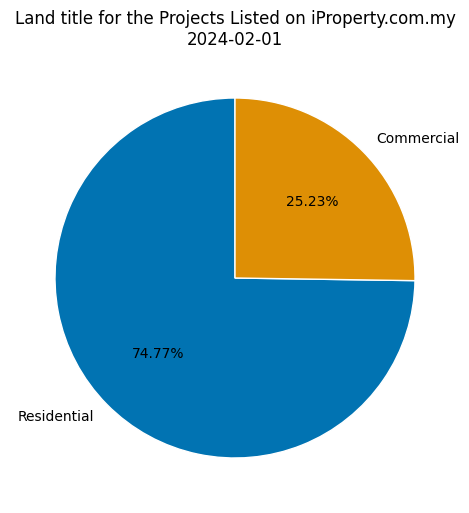

In [54]:
# draw pie chart for status, tenure and landtitle
draw_pie_chart_for_projects(df_unique_title, 'status', 'title', f"Status for the Projects Listed on iProperty.com.my\n{date}")
draw_pie_chart_for_projects(df_unique_title, 'tenure', 'title', f"Tenure for the Projects Listed on iProperty.com.my\n{date}")
draw_pie_chart_for_projects(df_unique_title, 'land_title', 'title', f"Land title for the Projects Listed on iProperty.com.my\n{date}")

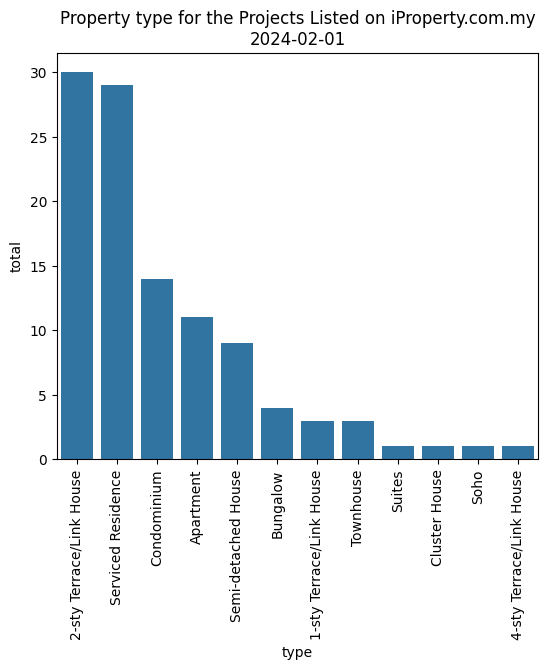

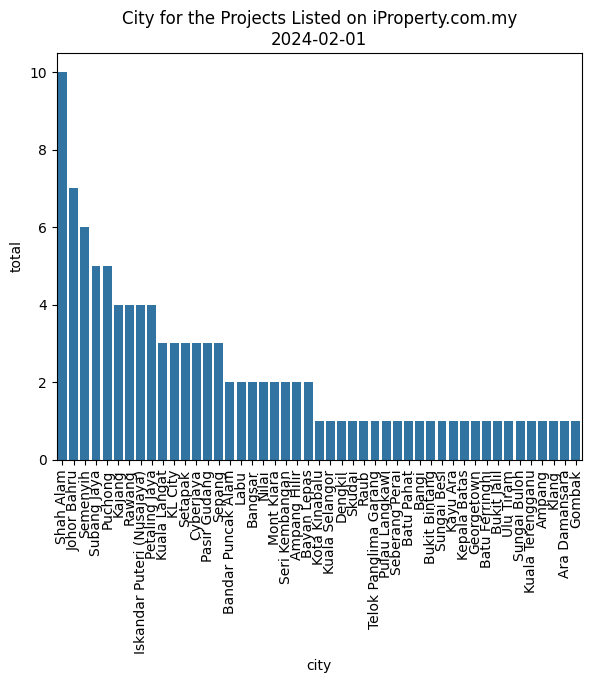

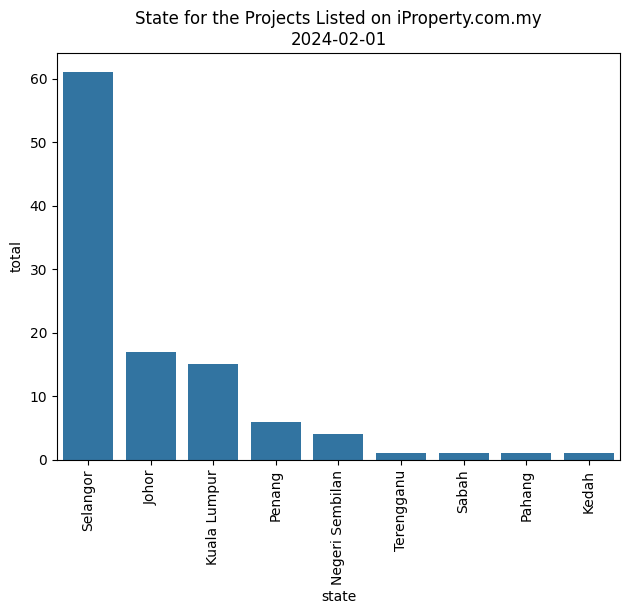

In [89]:
def draw_bar_chart_for_projects(data, target_column, agg_count_column, title):
    target = data[target_column].value_counts(sort=True).reset_index(name='total')
    sns.barplot(
        data=target,
        y='total',
        x=target_column)
    plt.tight_layout()
    plt.title(title)
    plt.xticks(rotation="vertical")
   
    plt.show() 
draw_bar_chart_for_projects(df_unique_title, 'type', 'title', f"Property type for the Projects Listed on iProperty.com.my\n{date}")
draw_bar_chart_for_projects(df_unique_title, 'city', 'title', f"City for the Projects Listed on iProperty.com.my\n{date}")
draw_bar_chart_for_projects(df_unique_title, 'state', 'title', f"State for the Projects Listed on iProperty.com.my\n{date}")

In [30]:
df_status = pd.pivot_table(df_unique_title, 
                     index = ["status"], 
                     values = ["title"], 
                     aggfunc = 'count')
df_status

,title
status,
Completed Project,9
New Launch,60
Open for Registration,13
Open for Sale,25


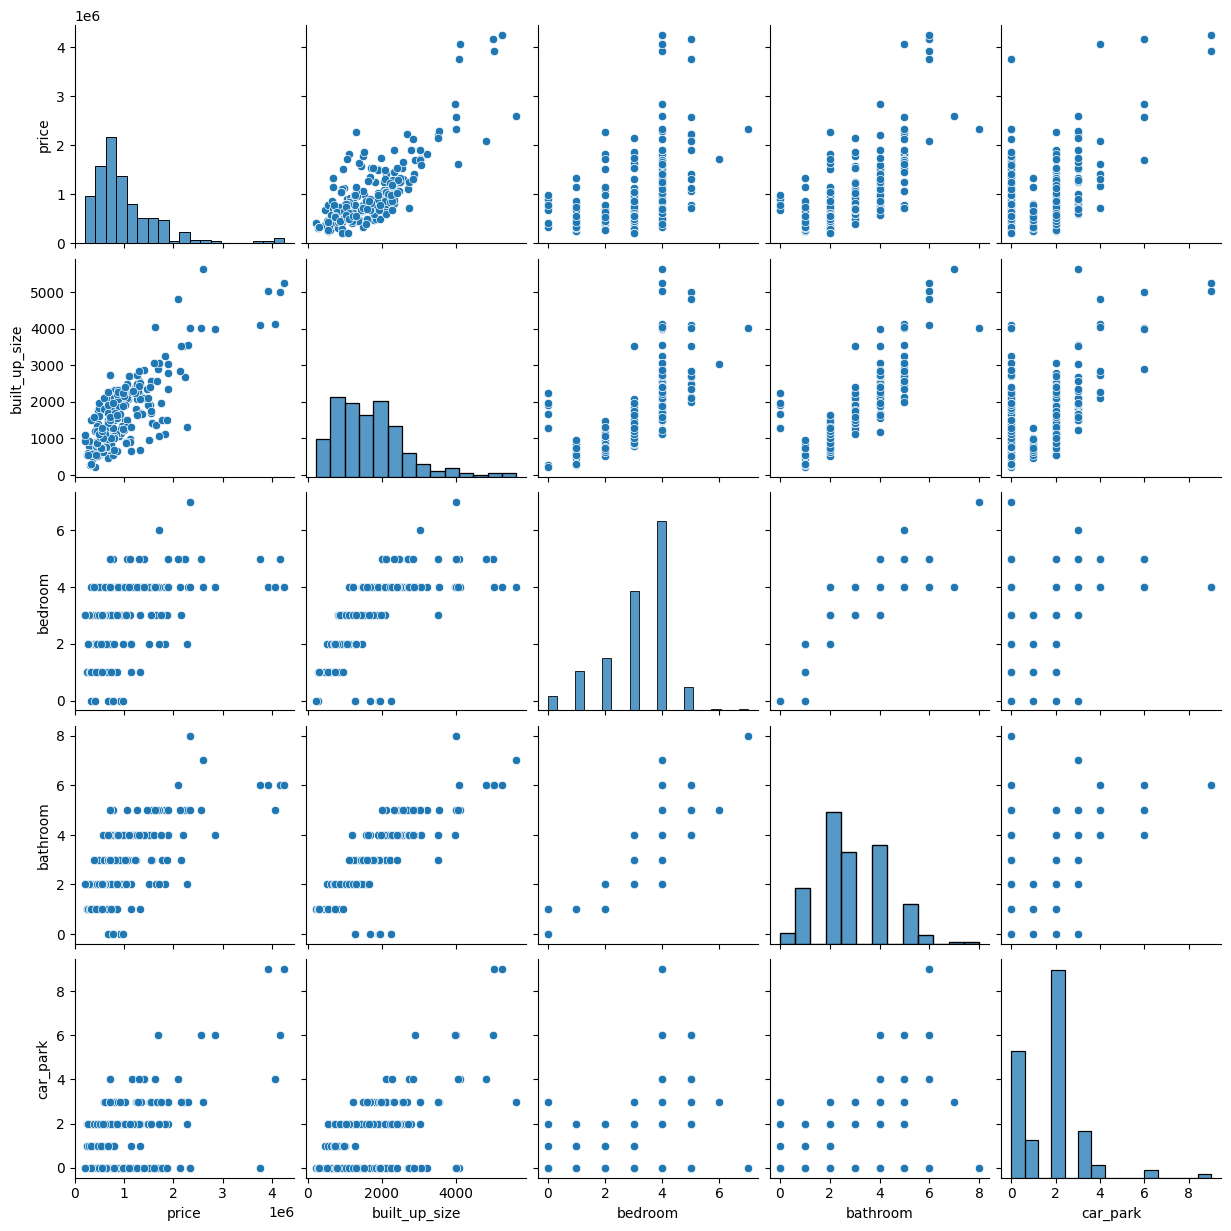

In [31]:
# check for relationships
sns.pairplot(data=df_house)
plt.show()